In [ ]:
# Written by Rikard Forlin
# rikard.forlin@ki.se

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

from matplotlib import rcParams
from tqdm import tqdm



# Hallmarks

In [2]:
hallmark_tnf = ["GEM", "CCL20", "MSC", "IL23A", "CD80", "TUBB2A", "IL1A", "IL6", "FOSL1", "DUSP4", "INHBA", "PLAU", "CD83",
                "F3", "CXCL2", "EDN1", "GFPT2","TRAF1", "SOCS3", "RCAN1","ZC3H12A", "PMEPA1", "SPSB1", "GADD45B", "GADD45A", "BTG3",
                "PPP1R15A", "SERPINB2", "ID2", "BIRC3", "SOD2", "HES1", "TNFAIP6", "G0S2", "EIF1", "CD44", "MAFF", "ICAM1", "MAP3K8",
               "YRDC", "BCL2A1", "DUSP2", "PFKFB3", "LAMB3", "EFNA1", "CLCF1", "TNIP2", "ZBTB10", "EGR2", "IL1B", "MAP2K3", "NR4A2",
               "CCND1", "TNFAIP2", "TNF", "TNFAIP8", "NFKB2", "KYNU", "TNFAIP3", "BCL6", "CEBPB", "NAMPT", "SLC2A6", "CCRL2"]

In [3]:
hallmark_ifna = ["CMTR1","HERC6", "IFIH1", "IFIT2", "OASL", "IRF7", "DDX60", "CNP", "RSAD2", "TMEM140", "OAS1", "PARP14", "TRIM5", "EIF2AK2", "LGALS3BP", "TRIM21", "STAT2", "PNPT1", "HELZ2", "USP18", "TXNIP", "GBP4", "RTP4", "TRAFD1", "MOV10",
                 "LY6E", "IFI35", "MX1", "ISG20", "CXCL11", "IFIT3", "SAMD9", "PARP12", "DHX58", "LPAR6", "IFITM3", "SELL", "ADAR", "TRIM25", "SP110", "NUB1", "IRF2", "GMPR", "ELF1"]


# Paths to data:

In [33]:
r848_v1_path = 'insert datapath here to ./scRNAseq_data/r848_v1.h5ad'
r848_v2_path = 'insert datapath here to ./scRNAseq_data/r848_v2.h5ad'

ntc_v1_path = 'insert datapath here to ./scRNAseq_data/ntc_v1.h5ad'
ntc_v2_path = 'insert datapath here to ./scRNAseq_data/ntc_v2.h5ad'

lps_v1_path = 'insert datapath here to ./scRNAseq_data/lps_v1.h5ad'
lps_v2_path = 'insert datapath here to ./scRNAseq_data/lps_v2.h5ad'


# Figure 3a - Barplots of R848 stim Monocytes

In [6]:
r848_v1 = sc.read_h5ad(r848_v1_path)
r848_v2 = sc.read_h5ad(r848_v2_path)

sc.pp.normalize_total(r848_v1, target_sum=1e4)
sc.pp.normalize_total(r848_v2, target_sum=1e4)

ct = 'Monocyte'
stim_v1 = r848_v1[r848_v1.obs.CellType == ct].to_df() 
stim_v2 = r848_v2[r848_v2.obs.CellType == ct].to_df()

stim_v1 = stim_v1.groupby(axis=1, level=0).sum()
stim_v2 = stim_v2.groupby(axis=1, level=0).sum()

#Comparing genes only found in both samples
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

### Creating inhouse btms

In [7]:

inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})

#btm_annotation table from Li et al: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3946932/
btm = pd.read_csv('../../btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]
btm_append = pd.concat([btm, inhouse_btms])



In [8]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append

#Calculate median of BTM-sum
for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTM-sum
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = pd.concat([genes_included, pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0])])
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [9]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

df_btm_v1 = pd.DataFrame({'module':btms_v1['module'], 'stim_values':btms_v1['sum'], 'V':'V1'})
df_btm_v2 = pd.DataFrame({'module':btms_v2['module'], 'stim_values':btms_v2['sum'], 'V':'V2'})


In [10]:
# Create the barplot:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

#Get the modules we are interested in:
modules = ['M5.0', 'M11.0', 'M71', 'M75', 'M111.1', 'M121', 'M127', 'M146', 'S5', 'Hallmark IFNa', 'Hallmark TNF']
barplot_df = barplot_df[barplot_df.module.isin(modules)]

Text(0.5, 1.0, 'Monocyte - R848 V1 and V2')

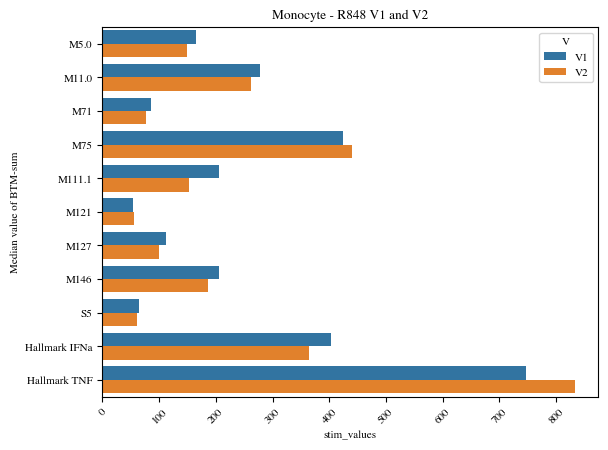

In [11]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45)
plt.ylabel('Median value of BTM-sum')
plt.title('Monocyte - R848 V1 and V2')
#plt.savefig('figures/Figure2/pDC_r848_BTMbarplots.svg')

### get pvalues from barplot


In [12]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Summarize BTMs for all cells
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1).values})
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
        
btms_v1 = dfs_btm[0]
btms_v2 = dfs_btm[1]

In [13]:
monocyte_r848_t_test = pd.DataFrame()
for m in modules:
    t_statistic, pvalue = stats.ttest_ind(a=np.log1p(btms_v1[m]), b=np.log1p(btms_v2[m]))
    temp = pd.DataFrame({'t_statistic': t_statistic, 'pvalue':pvalue}, index=[m])
    monocyte_r848_t_test = pd.concat([monocyte_r848_t_test, temp])

In [14]:
p_adjusted = multipletests(monocyte_r848_t_test['pvalue'], method='bonferroni')
monocyte_r848_t_test['p_adjusted'] = p_adjusted[1]

In [15]:
monocyte_r848_t_test

,t_statistc,pvalue,p_adjusted
M5.0,4.921013,9.698932e-07,1.066882e-05
M11.0,2.350626,1.888893e-02,2.077782e-01
M71,2.999236,2.757456e-03,3.033202e-02
M75,0.881608,3.781499e-01,1.000000e+00
M111.1,4.406442,1.136263e-05,1.249889e-04
M121,0.554062,5.796307e-01,1.000000e+00
M127,3.962904,7.802141e-05,8.582355e-04
M146,5.686596,1.594965e-08,1.754461e-07
S5,2.996671,2.780602e-03,3.058662e-02
Hallmark IFNa,4.035078,5.772880e-05,6.350168e-04


# Figure 3b - Barplots of LPS-stim monocytes

In [16]:
lps_v1 = sc.read_h5ad(lps_v1_path)
lps_v2 = sc.read_h5ad(lps_v2_path)

sc.pp.normalize_total(lps_v1, target_sum=1e4)
sc.pp.normalize_total(lps_v2, target_sum=1e4)

ct = 'Monocyte'
stim_v1 = lps_v1[lps_v1.obs.CellType == ct].to_df() 
stim_v2 = lps_v2[lps_v2.obs.CellType == ct].to_df()

stim_v1 = stim_v1.groupby(axis=1, level=0).sum()
stim_v2 = stim_v2.groupby(axis=1, level=0).sum()

stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [17]:

inhouse_btms = pd.DataFrame({'ID':['Hallmark IFNa', 'Hallmark TNF'], 'Module title': 'X', 'Composite name': ['Hallmark IFNa', 'Hallmark TNF'], 'Module category':'X', 'Annotation level':'X', 'Module member genes': [', '.join(hallmark_ifna), ', '.join(hallmark_tnf)]})

#btm_annotation table from Li et al: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3946932/
btm = pd.read_csv('../../btm_annotation_table.csv', sep = ';')
btm = btm[['ID', 'Module title','Composite name', 'Module category', 'Annotation level', 'Module member genes']]
btm_append = pd.concat([btm, inhouse_btms])



In [18]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

genes_included = pd.DataFrame(columns = ['Module', 'Genes'])

btm_file = btm_append

#Calculate median of BTM-sum
for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Take median of BTM-sum
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.median(np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1))}, index = [0])
        genes_included = pd.concat([genes_included, pd.DataFrame({'Module': btm_file.iloc[j, 0], 'Composite Name':btm_file.iloc[j,2],'Genes': [df.columns[df.columns.isin(markers)].values]}, index=[0])])
        
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
genes_included = genes_included.drop_duplicates(subset = 'Module')

In [19]:
btms_v1 = dfs_btm[0].T.reset_index()
btms_v2 = dfs_btm[1].T.reset_index()

btms_v1.columns = ['module', 'sum']
btms_v2.columns = ['module', 'sum']

df_btm_v1 = pd.DataFrame({'module':btms_v1['module'], 'stim_values':btms_v1['sum'], 'V':'V1'})
df_btm_v2 = pd.DataFrame({'module':btms_v2['module'], 'stim_values':btms_v2['sum'], 'V':'V2'})

In [20]:
# Create the barplot:
barplot_df = pd.concat([df_btm_v1, df_btm_v2])

#Get the modules we are interested in:
modules_lps = ['M13', 'M27.0', 'M29', 'M43.0', 'M86.1', 'M127', 'M165', 'Hallmark IFNa', 'Hallmark TNF']
barplot_df = barplot_df[barplot_df.module.isin(modules_lps)]

Text(0.5, 1.0, 'Monocyte - R848 V1 and V2')

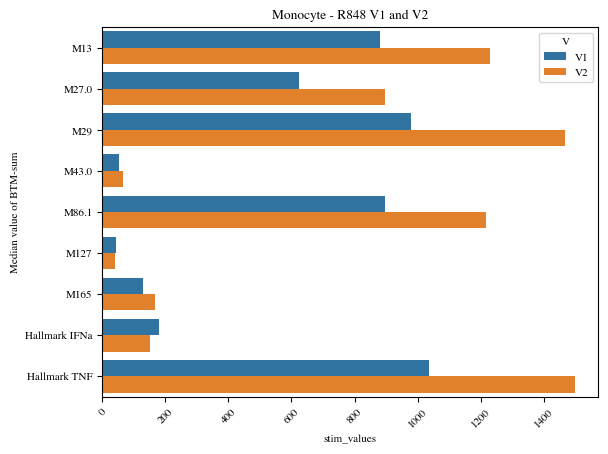

In [21]:
new_rc_params = {
"font.family": 'Times',
"font.size": 8,
"font.serif": [],
"svg.fonttype": 'none'} #to store text as text, not as path
plt.rcParams.update(new_rc_params)

sns.barplot(y = 'module', x = 'stim_values', data = barplot_df, hue = 'V')
plt.xticks(rotation = 45)
plt.ylabel('Median value of BTM-sum')
plt.title('Monocyte - R848 V1 and V2')
#plt.savefig('figures/Figure2/pDC_r848_BTMbarplots.svg')

### get pvalues from barplot


In [22]:
btm_df_V1 = pd.DataFrame()
btm_df_V2 = pd.DataFrame()

dfs_btm = [btm_df_V1, btm_df_V2]
dfs_data = [stim_v1, stim_v2]

btm_file = btm_append

for i,df in enumerate(dfs_data):
    for j in range(len(btm_file)):
        markers = re.findall(r"[\w'-]+", btm_file.iloc[j, 5])
        #Summarize BTMs for all cells
        temp = pd.DataFrame({btm_file.iloc[j, 0]:np.sum(df[df.columns[df.columns.isin(markers)]], axis = 1).values})
        dfs_btm[i] = pd.concat([dfs_btm[i], temp], axis = 1)
        
btms_v1 = dfs_btm[0]
btms_v2 = dfs_btm[1]

In [23]:
monocyte_lps_t_test = pd.DataFrame()
for m in modules:
    t_statistic, pvalue = stats.ttest_ind(a=np.log1p(btms_v1[m]), b=np.log1p(btms_v2[m]))
    temp = pd.DataFrame({'t_statistic': t_statistic, 'pvalue':pvalue}, index=[m])
    monocyte_lps_t_test = pd.concat([monocyte_lps_t_test, temp])

In [24]:
p_adjusted = multipletests(monocyte_lps_t_test['pvalue'], method='bonferroni')
monocyte_lps_t_test['p_adjusted'] = p_adjusted[1]

In [26]:
monocyte_lps_t_test

,t_statistc,pvalue,p_adjusted
M5.0,-4.741512,2.248487e-06,2.473336e-05
M11.0,-18.713465,6.087665e-73,6.696431e-72
M71,-8.139858,6.352306e-16,6.987537e-15
M75,-17.208517,1.361155e-62,1.497270e-61
M111.1,-4.834224,1.423183e-06,1.565501e-05
M121,-4.713496,2.577664e-06,2.835431e-05
M127,1.758395,7.881076e-02,8.669184e-01
M146,11.896526,9.899286e-32,1.088921e-30
S5,-15.620548,2.102766e-52,2.313043e-51
Hallmark IFNa,6.051634,1.664506e-09,1.830956e-08


# Figure 3c - violin plots for hallmark TNF

In [27]:
lps_v1 = sc.read_h5ad(lps_v1_path)
lps_v2 = sc.read_h5ad(lps_v2_path)

ntc_v1 = sc.read_h5ad(ntc_v1_path)
ntc_v2 = sc.read_h5ad(ntc_v2_path)

sc.pp.normalize_total(lps_v1, target_sum=1e4)
sc.pp.normalize_total(lps_v2, target_sum=1e4)
sc.pp.normalize_total(ntc_v1, target_sum=1e4)
sc.pp.normalize_total(ntc_v2, target_sum=1e4)




In [28]:
ct = 'Monocyte'
stim_v1 = lps_v1[lps_v1.obs.CellType == ct].to_df() 
stim_v2 = lps_v2[lps_v2.obs.CellType == ct].to_df() 


notstim_v1 = ntc_v1[ntc_v1.obs.CellType == ct].to_df()
notstim_v2 = ntc_v2[ntc_v2.obs.CellType == ct].to_df()


In [29]:
#Make sure columns are aligned within the two countmatrices
stim_v1 = stim_v1.groupby(axis=1, level=0).sum()
stim_v2 = stim_v2.groupby(axis=1, level=0).sum()
stim_v1 = stim_v1[stim_v1.columns[stim_v1.columns.isin(stim_v2.columns)]]
stim_v2 = stim_v2[stim_v2.columns[stim_v2.columns.isin(stim_v1.columns)]]

In [30]:
#Calculate median of the unstim - to normalise the stimulated data from
ntcmedian_v1 = notstim_v1.median()
ntcmedian_v2 = notstim_v2.median()

ntcmedian_v1 = ntcmedian_v1[ntcmedian_v1.index.isin(stim_v1.columns)]
ntcmedian_v2 = ntcmedian_v2[ntcmedian_v2.index.isin(stim_v2.columns)]

stim_v1_sub = stim_v1[ntcmedian_v1.index]
stim_v2_sub = stim_v2[ntcmedian_v2.index]

In [31]:
#Normalizing by subtracting median sum
stim_v1_sub = stim_v1_sub - ntcmedian_v1
stim_v2_sub = stim_v2_sub - ntcmedian_v2

In [34]:
#gene markers to look at:
markers = ['IL1A', 'IL1B', 'IL6', 'TNF', 'TNFAIP3', 'TNFAIP6', 'CD44', 'CXCL2', 'CCL20', 'NFKB1', 'SERPINB2', 'SOD2'] 

#Create violinplot
violin_df = pd.DataFrame()
for m in markers:
    temp1 = pd.DataFrame({'value': stim_v1_sub[m], 'gene':m, 'V':'V1'})
    temp2 = pd.DataFrame({'value': stim_v2_sub[m], 'gene':m, 'V':'V2'})
    both = pd.concat([temp2, temp1])
    violin_df = pd.concat([both, violin_df])
violin_df = violin_df.sort_values(by = 'gene')

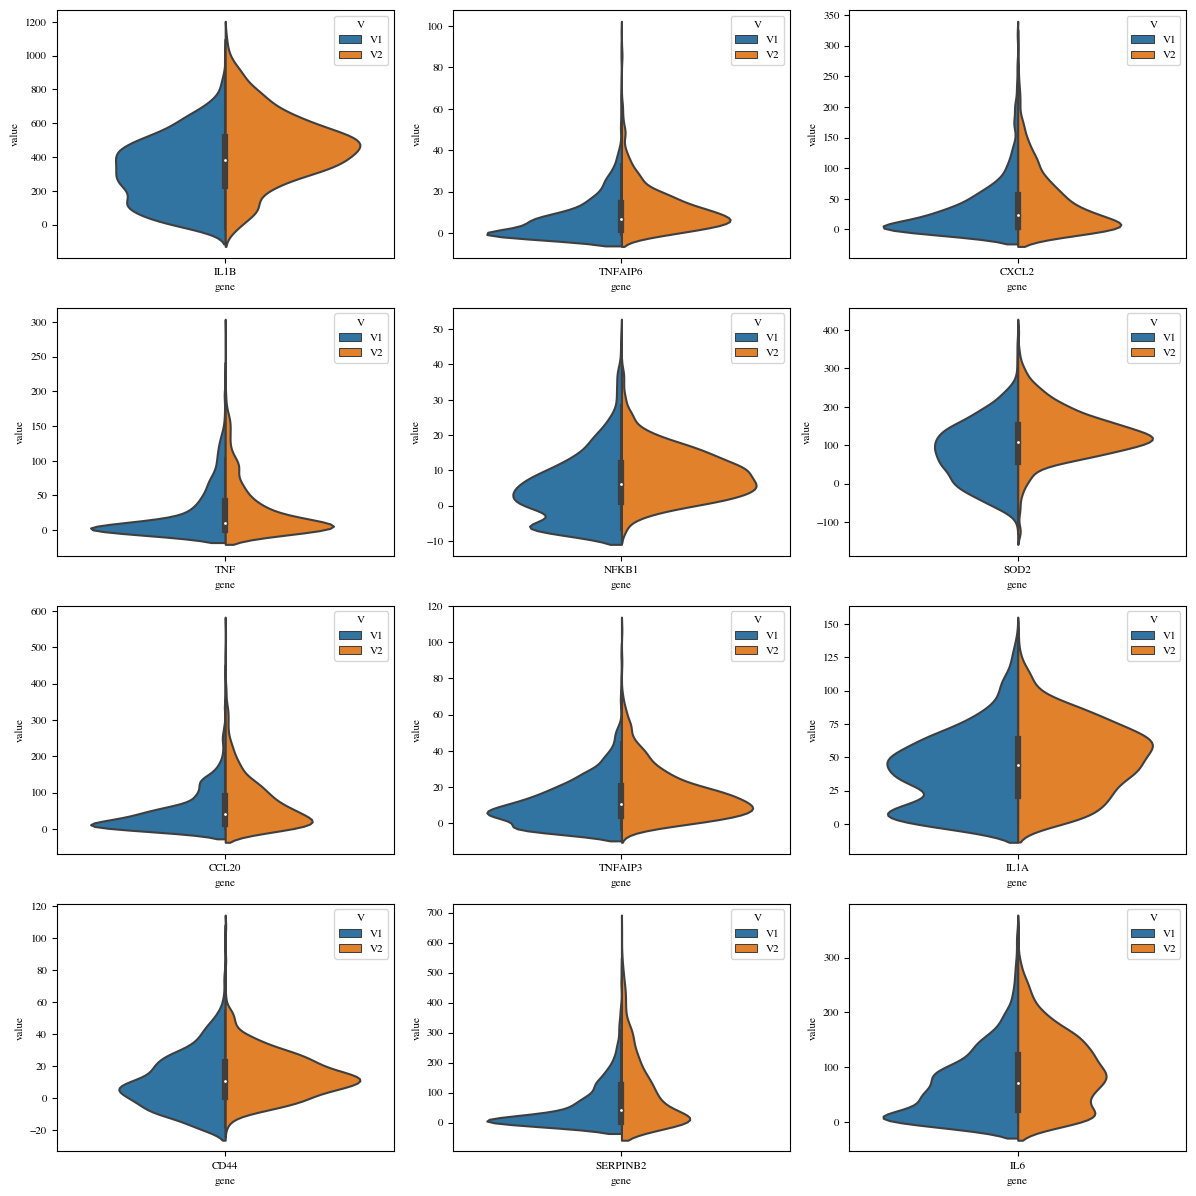

In [35]:
fig, axes = plt.subplots(4,3, figsize = (12,12))
axes = axes.flatten()
for i, gene in enumerate(set(violin_df.gene)):
    sns.violinplot(violin_df[violin_df.gene == gene], x = 'gene', y = 'value', hue = 'V', hue_order = ['V1', 'V2'], split = True, ax = axes[i]) 
    
plt.tight_layout()
#plt.savefig('figures/Figure3/Figure3_TNFgenes_violin_plots/TNF_genes_Monocytes.svg', bbox_inches = 'tight')

## pvalues for lps-stim monocytes violin plot

In [36]:
monos_lps_t_test = pd.DataFrame()
for g in set(violin_df.gene):
    t_statistic, pvalue = stats.ttest_ind(stim_v1_sub[g], stim_v2_sub[g] )
    temp = pd.DataFrame({'t_statistic': t_statistic, 'pvalue':pvalue}, index=[g])
    monos_lps_t_test = pd.concat([monos_lps_t_test, temp])

In [37]:
p_adjusted = multipletests(monos_lps_t_test['pvalue'], method='bonferroni')
monos_lps_t_test['p_adjusted'] = p_adjusted[1]

In [38]:
monos_lps_t_test

,t_statistc,pvalue,p_adjusted
IL1B,-17.099699,7.188462e-62,8.626154e-61
TNFAIP6,-9.820064,2.471460e-22,2.965752e-21
CXCL2,-6.001325,2.261224e-09,2.713469e-08
TNF,-3.650275,2.676860e-04,3.212232e-03
NFKB1,-10.957288,2.778399e-27,3.334079e-26
SOD2,-16.992408,3.679221e-61,4.415065e-60
CCL20,-8.808107,2.423610e-18,2.908332e-17
TNFAIP3,-9.466257,6.810101e-21,8.172121e-20
IL1A,-7.910103,3.926546e-15,4.711856e-14
CD44,-5.971912,2.701850e-09,3.242220e-08


# Figure 3e - SLAMF7 in LPS-stimulated monocytes

In [43]:
slamf7_hallmark = pd.DataFrame(columns = ['medianHallmark','posOrNeg', 'study/stim_sex/V'])

ct = 'Monocyte'
gene = 'SLAMF7'

hallmark = hallmark_tnf

V1 = sc.read(lps_v1_path)
V2 = sc.read(lps_v2_path)

sc.pp.normalize_total(V1, target_sum=1e4)
sc.pp.normalize_total(V2, target_sum=1e4)

ct_v1 = V1[V1.obs.CellType == ct].to_df()
ct_v2 = V2[V2.obs.CellType == ct].to_df()

v_stim_str_v1 = 'lps'
v_stim_str_v2 = v_stim_str_v1[0].upper() + '-' + 'V2'
v_stim_str_v1 = v_stim_str_v1[0].upper() + '-' + 'V1'

v1_slamf7_n = ct_v1[ct_v1[gene] == 0]
v1_slamf7_p = ct_v1[ct_v1[gene] > 0]

v2_slamf7_n = ct_v2[ct_v2[gene] == 0]
v2_slamf7_p = ct_v2[ct_v2[gene] > 0]    

slamf7_hallmark.loc[v_stim_str_v1+'negative'] = [np.median(np.sum(v1_slamf7_n[v1_slamf7_n.columns[v1_slamf7_n.columns.isin(hallmark)]], axis = 1)), 'negative', 'LPS-V1']
slamf7_hallmark.loc[v_stim_str_v1+'positive'] = [np.median(np.sum(v1_slamf7_p[v1_slamf7_p.columns[v1_slamf7_p.columns.isin(hallmark)]], axis = 1)), 'positive', 'LPS-V1']

slamf7_hallmark.loc[v_stim_str_v2+'negative'] = [np.median(np.sum(v2_slamf7_n[v2_slamf7_n.columns[v2_slamf7_n.columns.isin(hallmark)]], axis = 1)), 'negative', 'LPS-V2']
slamf7_hallmark.loc[v_stim_str_v2+'positive'] = [np.median(np.sum(v2_slamf7_p[v2_slamf7_p.columns[v2_slamf7_p.columns.isin(hallmark)]], axis = 1)), 'positive', 'LPS-V2']


Text(0.5, 1.0, 'SLAMF7(+) vs SLAMF7(-) Monocyte TNF hallmark')

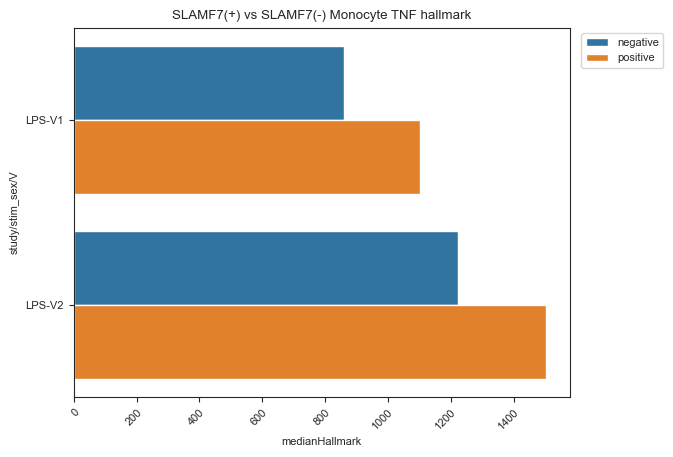

In [45]:

sns.barplot(slamf7_hallmark, y = 'study/stim_sex/V', x = 'medianHallmark', hue = 'posOrNeg')
plt.xticks(rotation = 45, ha = 'right', rotation_mode="anchor")
plt.legend(bbox_to_anchor=(1.2, 1))
plt.title('SLAMF7(+) vs SLAMF7(-) '+ct+ ' TNF hallmark')
#plt.savefig('figures/Figure3/Figure3_SLAMF7_hallmarkTNF/SLAMF7_Monocytes_LPS_V1vsV2.svg')

In [46]:
pval_v1nvsv1p = scipy.stats.ttest_ind(np.log1p(np.sum(v1_slamf7_n[v1_slamf7_n.columns[v1_slamf7_n.columns.isin(hallmark)]], axis = 1)), np.log1p(np.sum(v1_slamf7_p[v1_slamf7_p.columns[v1_slamf7_p.columns.isin(hallmark)]], axis = 1)))
pval_v2nvsv2p = scipy.stats.ttest_ind(np.log1p(np.sum(v2_slamf7_n[v2_slamf7_n.columns[v2_slamf7_n.columns.isin(hallmark)]], axis = 1)), np.log1p(np.sum(v2_slamf7_p[v2_slamf7_p.columns[v2_slamf7_p.columns.isin(hallmark)]], axis = 1)))




In [47]:
pvals_slamf7 = pd.DataFrame({'v1neg_vs_v1pos': pval_v1nvsv1p[1], 'v2neg_vs_v2pos': pval_v2nvsv2p[1]}, index = ['p-values'])
pvals_slamf7 = pvals_slamf7.T


In [48]:
pvals_slamf7

,p-values
v1neg_vs_v1pos,5.089169e-16
v2neg_vs_v2pos,2.683518e-18


### Proportion of positive and negative SLAMF7 cells

In [49]:
print(len(ct_v1[ct_v1['SLAMF7'].astype(bool) == True]) / len(ct_v1))
print(len(ct_v2[ct_v2['SLAMF7'].astype(bool) == True]) / len(ct_v2))

0.7424826522744795
0.98


# Figure 3f Log2 counts of IFNGR1, IFNGR2 and SLAMF7 lps-stim

In [50]:

ct = 'Monocyte'

V1 = sc.read(lps_v1_path)
V2 = sc.read(lps_v2_path)

sc.pp.normalize_total(V1, target_sum=1e4)
sc.pp.normalize_total(V2, target_sum=1e4)

ct_v1 = V1[V1.obs.CellType == ct].to_df()
ct_v2 = V2[V2.obs.CellType == ct].to_df()

v_stim_str_v1 = 'lps'
v_stim_str_v2 = v_stim_str_v1[0].upper() + '-' + 'V2'
v_stim_str_v1 = v_stim_str_v1[0].upper() + '-' + 'V1'

In [51]:
ct_v1f = pd.DataFrame(np.round(np.mean(ct_v1[['IFNGR1', 'IFNGR2', 'SLAMF7']]), 2))
ct_v2f = pd.DataFrame(np.round(np.mean(ct_v2[['IFNGR1', 'IFNGR2', 'SLAMF7']]), 2))

In [52]:
# log2foldchange according to: https://www.biostars.org/p/342756/
log2FC_ifngr1 = np.mean(np.log1p(ct_v2['IFNGR1'])) - np.mean(np.log1p(ct_v1['IFNGR1']))
log2FC_ifngr2 = np.mean(np.log1p(ct_v2['IFNGR2'])) - np.mean(np.log1p(ct_v1['IFNGR2']))
log2FC_slamf7 = np.mean(np.log1p(ct_v2['SLAMF7'])) - np.mean(np.log1p(ct_v1['SLAMF7']))


In [53]:
pval_ifngr1 = np.round(scipy.stats.ttest_ind(np.log1p(ct_v1['IFNGR1']), np.log1p(ct_v2['IFNGR1']))[1], 3)
pval_ifngr2 = np.round(scipy.stats.ttest_ind(np.log1p(ct_v1['IFNGR2']), np.log1p(ct_v2['IFNGR2']))[1], 15)
pval_slamf7 = np.round(scipy.stats.ttest_ind(np.log1p(ct_v1['SLAMF7']), np.log1p(ct_v2['SLAMF7']))[1], 5)

In [54]:
barplot_log2fc = pd.DataFrame({'values': [log2FC_ifngr1, log2FC_ifngr2, log2FC_slamf7], 'gene':['IFNGR1\npvalue:'+str(pval_ifngr1), 'IFNGR2\npvalue:'+str(pval_ifngr2), 'SLAMF7\npvalue'+str(pval_slamf7)],})


Text(0.5, 1.0, 'log2FC - Monos LPS V2 vs V1')

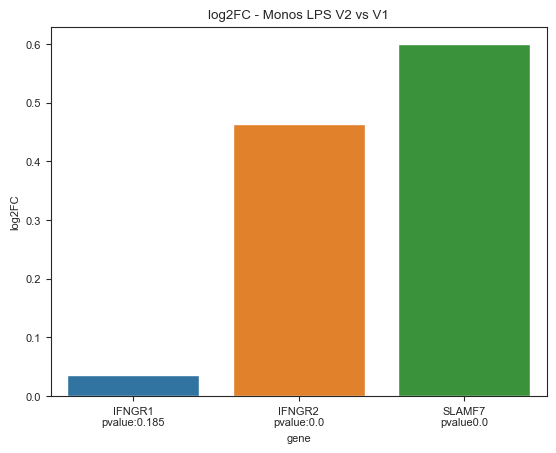

In [56]:
sns.barplot(barplot_log2fc, x = 'gene', y = 'values')
plt.ylabel('log2FC')
plt.title('log2FC - Monos LPS V2 vs V1')